# Directory check


In [ ]:
import os

current_directory = os.getcwd()

absolute_path = os.path.abspath(os.path.join(current_directory,"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_outputscaling_beta_tests/softmax_fixed_beta/softmax_5"))

print(absolute_path)

# Analysis class and auxiliar functions

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

class Analysis:
    def __init__(self, path_to_dir):
        self.path = path_to_dir
        separated_data = {
            'episode_reward': [],
            'loss': [],
            'runtime': [],
            'params_gradients': [],
            'input_params_gradients': []
        }

        for subdir, dirs, files in os.walk(self.path):
            for file in files:
                if file.endswith('.npz'):
                    file_path = os.path.join(subdir, file)
                    if os.path.exists(file_path):
                        data = np.load(file_path, allow_pickle=True)
                        for key in separated_data:
                            if key in data:
                                separated_data[key].append(data[key].tolist())

        self.data = separated_data

    def get_rewards(self):
        for agent in self.data["episode_reward"]:
            while len(agent) < 1000:
                agent.append(agent[-1])
        return self.data["episode_reward"]

    def get_loss(self):
        return self.data["loss"]

    def get_runtime(self):
        return self.data["runtime"]

    def get_gradients(self):
        return self.data["params_gradients"]

    def get_input_gradients(self):
        return self.data["input_params_gradients"]

    def get_moving_average(self, window_size=10):
        rewards = self.get_rewards()
        moving_averages = []
        for reward in rewards:
            moving_averages.append(pd.Series(reward).rolling(window_size).mean())
        return moving_averages

    def calculate_mean_variance_gradients(self, return_max=False, return_min=False):
        gradients = self.get_gradients()
        
        # Ensure all gradients have the same length
        min_length = min(len(grad) for grad in gradients)
        gradients = [grad[:min_length] for grad in gradients]

        def flatten_gradients(grads):
            for i in range(len(grads)):
                for j in range(len(grads[i])):
                    grads[i][j] = np.concatenate(
                        [arr.flatten() if isinstance(arr, np.ndarray) else np.array([arr]) for arr in grads[i][j]], 
                        axis=0
                    )

        # Flatten the gradients across agents and episodes
        flatten_gradients(gradients)
        
        # Convert to numpy array for easy manipulation
        gradients_array = np.array(gradients)
        
        # Calculate magnitudes of the gradients
        magnitudes = np.linalg.norm(gradients_array, axis=2)
        
        # Compute mean and variance (standard deviation) of magnitudes
        mean_magnitudes = np.mean(magnitudes, axis=0)
        std_magnitudes = np.var(magnitudes, axis=0)
        
        # Optionally compute max and min magnitudes with their indices
        max_magnitudes = np.max(magnitudes, axis=0)
        min_magnitudes = np.min(magnitudes, axis=0)
        max_index = np.argmax(gradients_array, axis=2)
        min_index = np.argmin(gradients_array, axis=2)
        
        # Return the desired statistics based on function arguments
        if return_max and return_min:
            return mean_magnitudes, std_magnitudes, max_magnitudes, max_index, min_magnitudes, min_index
        elif return_max:
            return mean_magnitudes, std_magnitudes, max_magnitudes, max_index
        elif return_min:
            return mean_magnitudes, std_magnitudes, min_magnitudes, min_index
        else:
            return mean_magnitudes, std_magnitudes

    def calculate_mean_variance_input_gradients(self, return_max=False, return_min=False):
        gradients = self.get_input_gradients()
        # Ensure all gradients have the same length
        min_length = min(len(grad) for grad in gradients)
        gradients = [grad[:min_length] for grad in gradients]

        def flatten_gradients(grads):
            for i in range(len(grads)):
                for j in range(len(grads[i])):
                    grads[i][j] = np.concatenate(
                        [arr.flatten() if isinstance(arr, np.ndarray) else np.array([arr]) for arr in grads[i][j]], 
                        axis=0
                    )

        # Flatten the gradients across agents and episodes
        flatten_gradients(gradients)
        
        # Convert to numpy array for easy manipulation
        gradients_array = np.array(gradients)
        
        # Calculate magnitudes of the gradients
        magnitudes = np.linalg.norm(gradients_array, axis=2)
        
        # Compute mean and variance (standard deviation) of magnitudes
        mean_magnitudes = np.mean(magnitudes, axis=0)
        std_magnitudes = np.var(magnitudes, axis=0)
        
        # Optionally compute max and min magnitudes with their indices
        max_magnitudes = np.max(magnitudes, axis=0)
        min_magnitudes = np.min(magnitudes, axis=0)
        max_index = np.argmax(gradients_array, axis=2)
        min_index = np.argmin(gradients_array, axis=2)
        
        # Return the desired statistics based on function arguments
        if return_max and return_min:
            return mean_magnitudes, std_magnitudes, max_magnitudes, max_index, min_magnitudes, min_index
        elif return_max:
            return mean_magnitudes, std_magnitudes, max_magnitudes, max_index
        elif return_min:
            return mean_magnitudes, std_magnitudes, min_magnitudes, min_index
        else:
            return mean_magnitudes, std_magnitudes
        

def get_mean(path):
    run = Analysis(path)
    rewards = run.get_rewards()
    return(np.mean(rewards, axis=0))

def get_std(path):
    run = Analysis(path)
    rewards = run.get_rewards()
    return(np.std(rewards, axis=0))

def get_moving_mean(path, window):
    run = Analysis(path)
    rewards = run.get_moving_average(window)
    return(np.mean(rewards, axis=0))

def get_moving_std(path, window):
    run = Analysis(path)
    rewards = run.get_moving_average(window)
    return(np.std(rewards, axis=0))

def rewards_plot(paths, title = None, labels = None, y_lims=[0,500]):
    colors = ['blue', 'green', 'red', 'orange', 'yellow', 'cyan', 'magenta', 'black', 'white', 'gray']

    plt.rcParams['figure.figsize'] = [14, 7]

    for i, path in enumerate(paths):
        plt.plot(get_mean(path), color= colors[i], label=labels[i])

    for i, path in enumerate(paths):
        plt.fill_between(np.arange(len(get_mean(path))), 
                         np.clip(get_mean(path) - get_std(path), a_min=y_lims[0], a_max=y_lims[1]), 
                         np.clip(get_mean(path) + get_std(path), a_min = y_lims[0], a_max = y_lims[1]), 
                         alpha=0.15, color= colors[i])
    
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Mean Return")
    plt.ylim(y_lims[0], y_lims[1])
    plt.legend(loc = "upper right")
    plt.grid(True)
    #plt.savefig('../../graphs/skolik_baseline.pdf')  
    plt.show()

def moving_rewards_plot(paths, labels = None, window=10, y_lims=[0,500]):
    colors = ['blue', 'green', 'red', 'orange', 'yellow', 'cyan', 'magenta', 'black', 'white', 'gray']

    plt.rcParams['figure.figsize'] = [14, 7]

    for i, path in enumerate(paths):
        plt.plot(get_moving_mean(path, window), color= colors[i], label=labels[i])
        plt.fill_between(np.arange(len(get_moving_mean(path, window))), 
                         np.clip(get_moving_mean(path, window) - get_moving_std(path, window), a_min=y_lims[0], a_max=y_lims[1]), 
                         np.clip(get_moving_mean(path, window) + get_moving_std(path, window), a_min = y_lims[0], a_max = y_lims[1]), 
                         alpha=0.15, color= colors[i])
    
    plt.xlabel("Episode")
    plt.ylabel("Mean Return")
    plt.ylim(y_lims[0], y_lims[1])
    plt.legend(loc = "upper right")
    plt.grid(True)
    #plt.savefig('../../graphs/skolik_baseline.pdf')  
    plt.show()

def plot_mean_variance_gradients(paths, labels=None, window_size = 10):
    colors = ['blue', 'green', 'red', 'orange', 'yellow', 'cyan', 'magenta', 'black', 'white', 'gray']

    plt.rcParams['figure.figsize'] = [14, 7]
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
    
    # To store y-limits for each plot
    y_limits = {'mean': [float('inf'), float('-inf')], 'std': [float('inf'), float('-inf')]}

    # Plot mean values
    for i, path in enumerate(paths):
        run = Analysis(path)
        mean_values, _ = run.calculate_mean_variance_gradients()
        mean_values_smoothed = pd.Series(mean_values).rolling(window_size).mean()
        axs[0].plot(mean_values_smoothed, color=colors[i], label=labels[i])
        
        # Update y-limits
        y_limits['mean'][0] = min(y_limits['mean'][0], mean_values_smoothed.min())
        y_limits['mean'][1] = max(y_limits['mean'][1], mean_values_smoothed.max())
    
    axs[0].set_xlabel("Episode", fontsize=12)
    axs[0].set_ylabel("Mean Gradient Norm", fontsize=12)
    axs[0].legend(fontsize=12)
    axs[0].xaxis.set_tick_params(labelsize=12)
    axs[0].yaxis.set_tick_params(labelsize=12)
    axs[0].grid(True)
    
    # Plot std values
    for i, path in enumerate(paths):
        run = Analysis(path)
        _, std_values = run.calculate_mean_variance_gradients()
        std_values_smoothed = pd.Series(std_values).rolling(window_size).mean()
        axs[1].plot(std_values_smoothed, color=colors[i], label=labels[i])
        
        # Update y-limits
        y_limits['std'][0] = min(y_limits['std'][0], std_values_smoothed.min())
        y_limits['std'][1] = max(y_limits['std'][1], std_values_smoothed.max())
    
    axs[1].set_xlabel("Episode", fontsize=12)
    axs[1].set_ylabel("Variance of the Gradient Norm", fontsize=12)
    axs[1].legend(fontsize=12)
    axs[1].xaxis.set_tick_params(labelsize=12)
    axs[1].yaxis.set_tick_params(labelsize=12)
    axs[1].grid(True)
    
    # Set y-limits for each subplot
    axs[0].set_ylim(y_limits['mean'])
    axs[1].set_ylim(y_limits['std'])
    
    plt.show()

# Chain entanglement


## Number of layers study

In [ ]:
raw_contiguous_paths = ["../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_1layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_2layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_3layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_4layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_5layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_contiguous_6layer"]

raw_parity_paths = ["../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_1layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_2layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_3layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_4layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_5layer",
                        "../../../../data/CartPole-v1/jerbi/chain/raw-policy/raw_parity_6layer"]

### Episodes average

In [ ]:
rewards_plot(raw_contiguous_paths, 'Episode Rewards for Raw Contiguous Policy', ['Raw Contiguous 1','Raw Contiguous 2','Raw Contiguous 3','Raw Contiguous 4','Raw Contiguous 5','Raw Contiguous 6'])

In [ ]:
moving_rewards_plot(raw_contiguous_paths, 'Episode Rewards for Raw Contiguous Policy', ['Raw Contiguous 1','Raw Contiguous 2','Raw Contiguous 3','Raw Contiguous 4','Raw Contiguous 5','Raw Contiguous 6'])

# All for All entanglement

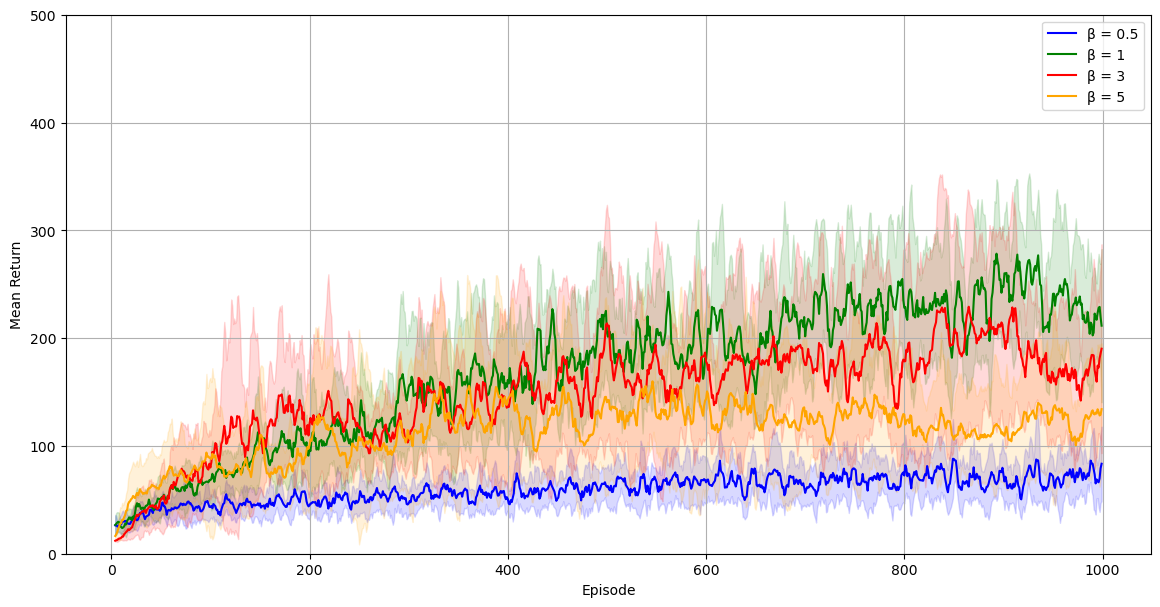

In [14]:
softmax_fixed_betas_paths =["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_05",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_1",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_3",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_fixed_beta/softmax_5"]

moving_rewards_plot(softmax_fixed_betas_paths, ['\u03B2 = 0.5','\u03B2 = 1','\u03B2 = 3','\u03B2 = 5'], 5)

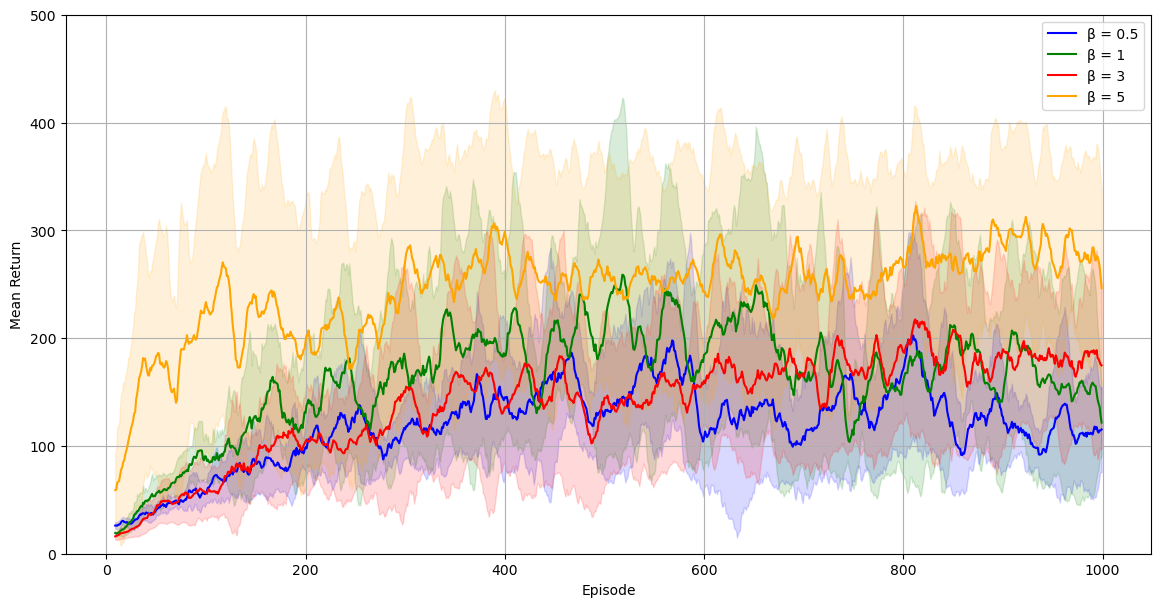

In [13]:
softmax_different_starting_betas_path = ["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/05beta",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/1beta",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/3beta",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_different_starting_beta/5beta"]

moving_rewards_plot(softmax_different_starting_betas_path, ['\u03B2 = 0.5','\u03B2 = 1','\u03B2 = 3','\u03B2 = 5'],10)

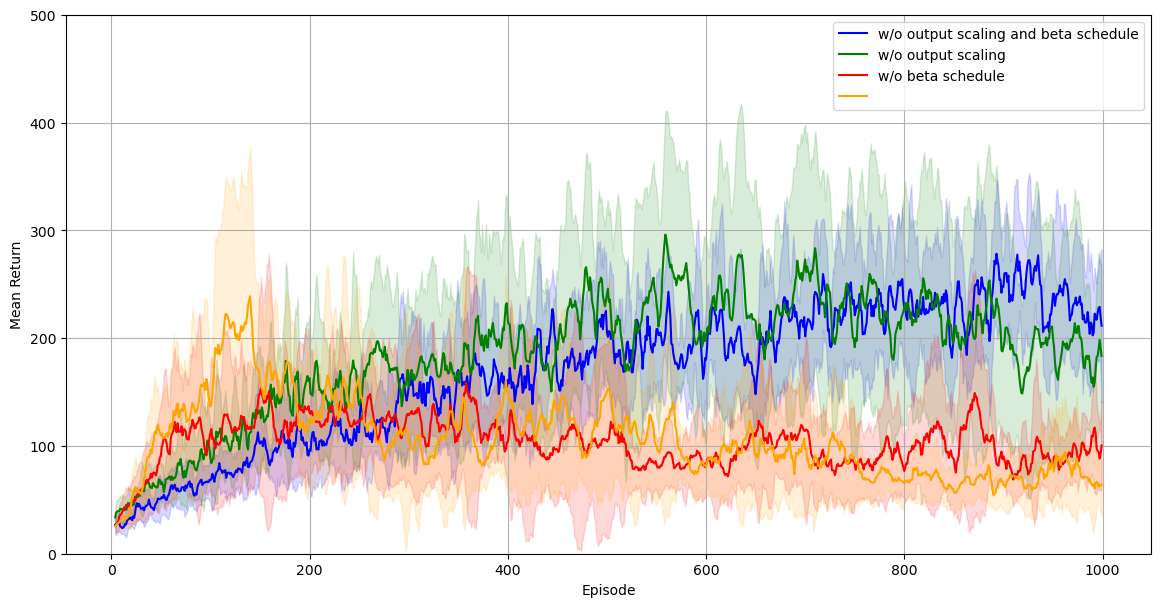

In [15]:
softmax_output_betaschedule_path = ["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1",
                                    "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1beta",
                                    "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1output",
                                    "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_betaschedule_tests/softmax_1beta_output"]


moving_rewards_plot(softmax_output_betaschedule_path, ['w/o output scaling and beta schedule','w/o output scaling','w/o beta schedule',' '], 5)

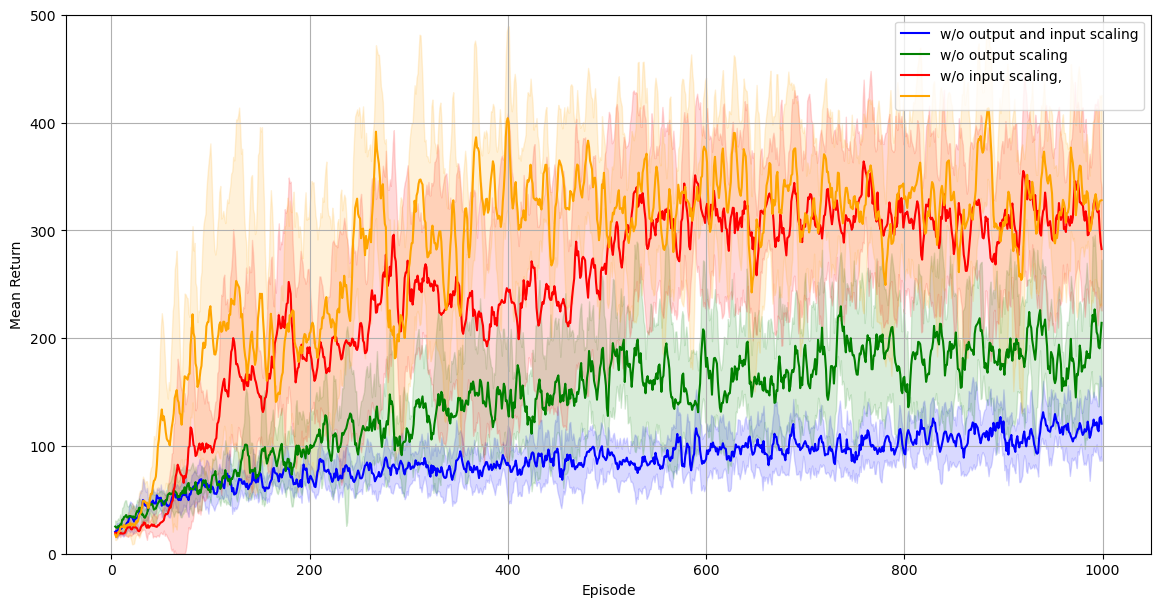

In [16]:
softmax_output_input_path= ["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_false_output_scalling_false",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_true_output_scalling_false",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_false_output_scalling_true",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_true_output_scalling_true"]

moving_rewards_plot(softmax_output_input_path, ['w/o output and input scaling','w/o output scaling','w/o input scaling,',' '], 5)

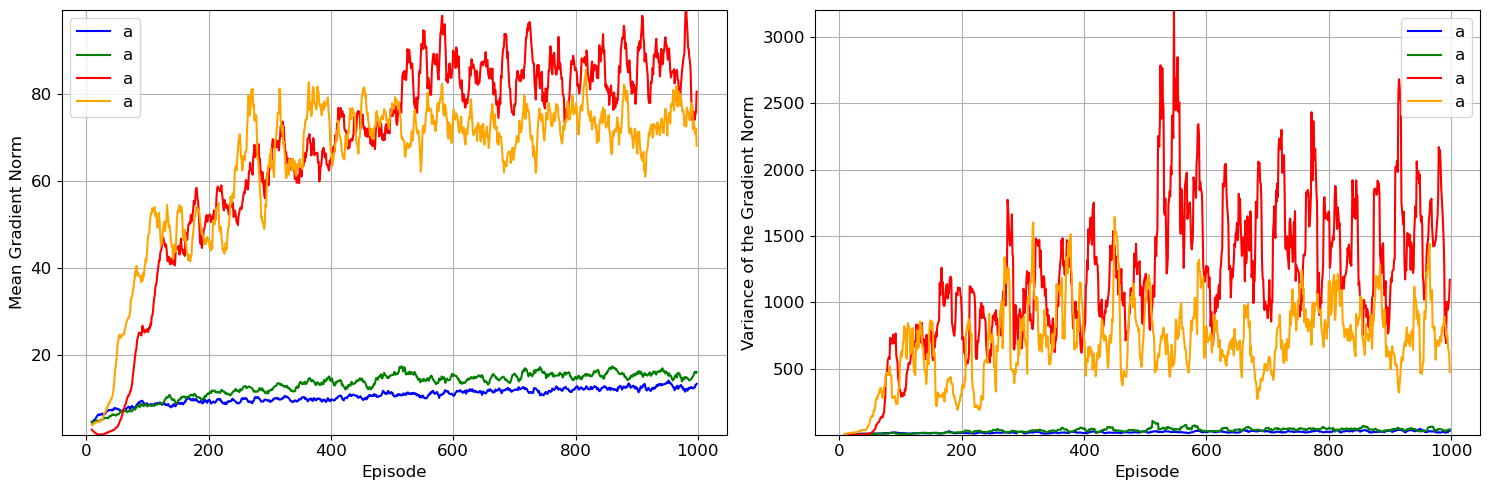

In [26]:
test_path= ["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_false_output_scalling_false",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_true_output_scalling_false",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_false_output_scalling_true",
"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_output_input_tests/input_scaling_true_output_scalling_true"]


plot_mean_variance_gradients(test_path, ['a','a','a','a'])

In [ ]:
softmax_fixed_betas_paths =["../../../../data/CartPole-v1/jerbi/all_for_all/softmax/output_dim_tests/output_1_dim",
                            "../../../../data/CartPole-v1/jerbi/all_for_all/softmax/output_dim_tests/output_n_actions_dim"]

moving_rewards_plot(softmax_fixed_betas_paths, ' ', ['1 Dimension','N Dimension'], 10)